# Hourly Bandwidth Prediction
This notebook predicts bandwidth usage per hour using time series features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('fivethirtyeight')
sns.set()

In [ ]:
# Load and prepare data
df = pd.read_csv('/content/Last2_months_with_weekend_encoded_with_holiday_copy.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df.head()

,Gbps,target,hour,dayofweek,dayofyear,month,lag_1,lag_2,lag_3,lag_24,...,rolling_std_24,is_weekend,is_holiday,is_offer,is_event,is_political_gathering,is_powercut,is_rain,event,is_drama
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-04 10:12:00,111.096774,111.096774,10,4,94,4,0.000000,0.000000,0.000000,0.0,...,0.000000,1,0,0,0,0,0,0,0,0
2025-04-04 11:38:00,111.096774,111.096774,11,4,94,4,111.096774,0.000000,0.000000,0.0,...,22.677534,1,0,0,0,0,0,0,0,0
2025-04-04 13:03:00,111.096774,111.096774,13,4,94,4,111.096774,111.096774,0.000000,0.0,...,31.365936,1,0,0,0,0,0,0,0,0
2025-04-04 14:29:00,117.870968,117.870968,14,4,94,4,111.096774,111.096774,111.096774,0.0,...,37.532041,1,0,0,0,0,0,0,0,0
2025-04-04 15:55:00,118.774193,118.774193,15,4,94,4,117.870968,111.096774,111.096774,0.0,...,42.955963,1,0,0,0,0,0,0,0,0


In [ ]:
# Feature engineering for hourly prediction
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)
df['is_political_gathering'] = df['is_political_gathering'].astype(int)
df['is_offer']= df['is_offer'].astype(int)
df['is_event'] = df['is_event'].astype(int)
df['is_powercut']=df['is_powercut'].astype(int)
df['is_political_gathering']=df['is_political_gathering'].astype(int)
df['is_drama']=df['is_drama'].astype(int)
df['event']=df['event'].astype(int)
df['is_rain']=df['is_rain'].astype(int)


# Lag features
df['lag_1'] = df['Gbps'].shift(1)
df['lag_2'] = df['Gbps'].shift(2)
df['lag_3'] = df['Gbps'].shift(3)
df['lag_24'] = df['Gbps'].shift(24)

# Rolling window features
df['rolling_mean_3'] = df['Gbps'].shift(1).rolling(window=3).mean()
df['rolling_std_3'] = df['Gbps'].shift(1).rolling(window=3).std()
df['rolling_mean_24'] = df['Gbps'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['Gbps'].shift(1).rolling(window=24).std()

# Drop NA
df = df.dropna()
df.head()

,Gbps,target,hour,dayofweek,dayofyear,month,lag_1,lag_2,lag_3,lag_24,...,is_offer,is_event,is_political_gathering,is_powercut,is_rain,event,is_drama,day,rolling_mean_3,rolling_std_3
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-05 20:27:00,97.096774,97.096774,20,5,95,4,98.451613,116.516129,116.516129,111.096774,...,0,0,0,0,1,0,0,5,110.494624,10.429553
2025-04-05 21:52:00,93.935484,93.935484,21,5,95,4,97.096774,98.451613,116.516129,111.096774,...,0,0,0,0,0,0,0,5,104.021505,10.841845
2025-04-05 23:18:00,69.096774,69.096774,23,5,95,4,93.935484,97.096774,98.451613,111.096774,...,0,0,0,0,0,0,0,5,96.494624,2.317497
2025-04-06 00:44:00,69.548387,69.548387,0,6,96,4,69.096774,93.935484,97.096774,117.870968,...,0,0,0,0,0,0,0,6,86.709677,15.334902
2025-04-06 02:09:00,99.354839,99.354839,2,6,96,4,69.548387,69.096774,93.935484,118.774193,...,0,0,0,0,0,0,0,6,77.526882,14.212060


In [ ]:
# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

FEATURES = ['hour', 'dayofweek', 'day', 'month', 'is_weekend', 'is_holiday', 'is_political_gathering','is_event',
            'lag_1', 'lag_2', 'lag_3', 'lag_24','event','is_rain','is_offer','is_drama',
            'rolling_mean_3', 'rolling_std_3', 'rolling_mean_24', 'rolling_std_24', 'is_powercut']
TARGET = 'Gbps'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict
test['prediction'] = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE: {rmse:.4f}')

RMSE: 13.6309


/tmp/ipython-input-5-641167465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


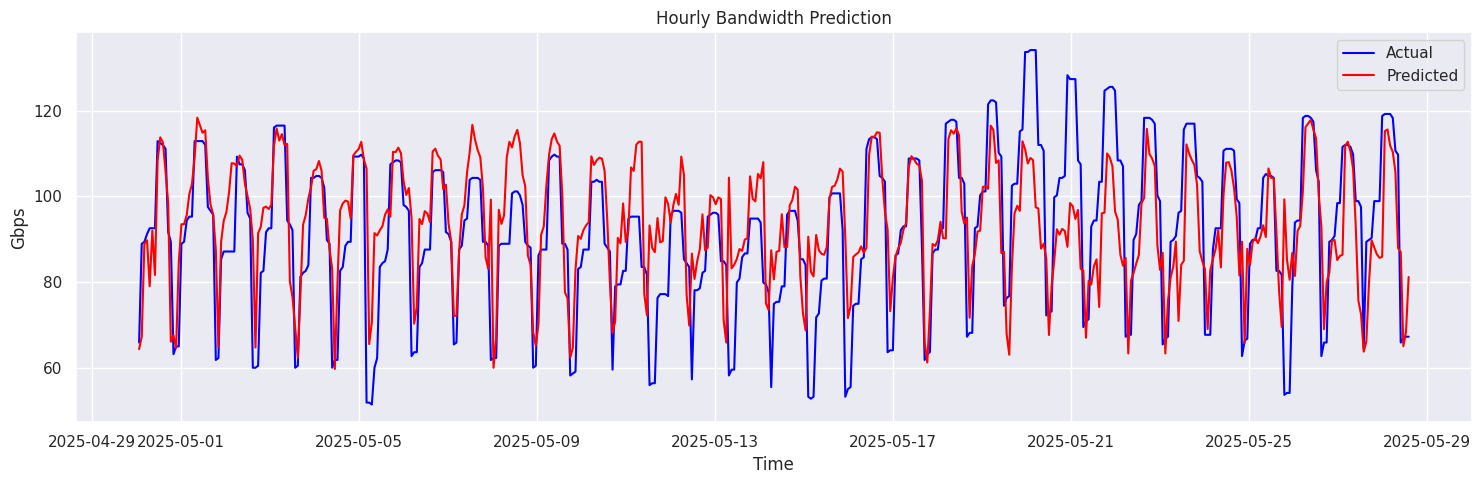

In [ ]:
# Plot hourly predictions
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, test['prediction'], label='Predicted', color='red')
plt.title('Hourly Bandwidth Prediction')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

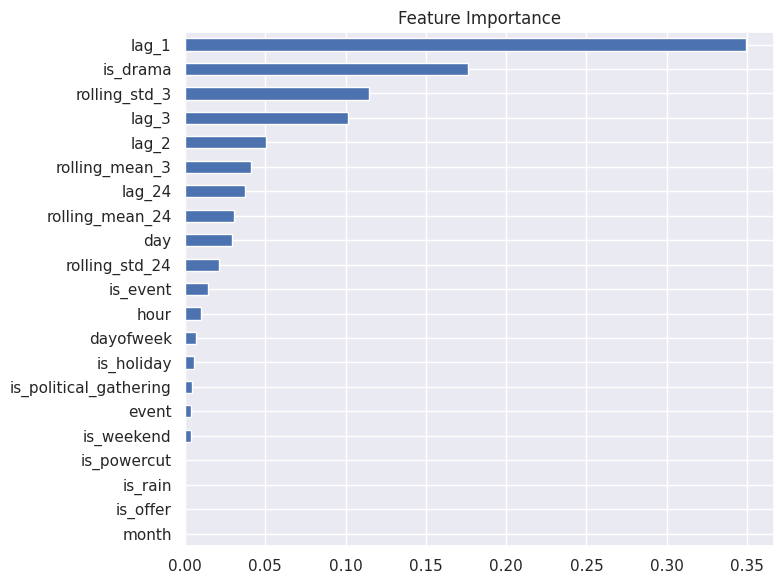

In [ ]:
# Feature importance plot
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=FEATURES).sort_values()
feat_imp.plot(kind='barh', title='Feature Importance', figsize=(8,6))
plt.tight_layout()
plt.show()

In [ ]:
model.save_model('bw_predictor.h5')

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [15:55:13] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [ ]:
model.save_model('bw_predictor.json')